# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>**attention**</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

<h2>Learning Objectives:

*  **Understand the Transformer Architecture**: Gain a comprehensive understanding of the transformer model architecture.

*  **Develop the  Encoder and Decoder Modules**: Understand the individual components of the transformer's encoder and decoder modules, including positional encoding, multi-head attention, and feed-forward projections.

*  **Integrate the Complete Transformer Model**:  Combine the encoder and decoder modules to construct the full transformer model, and learn how to manage the flow of information between these components.

* **Understand the Value of Multi-Head Attention**: Learn how to use the multi-head attention mechanism and understand its significance in improving the model's ability to focus on different parts of the input sequence simultaneously.

* **Understand and Apply Pretraining Techniques**: Grasp the concept of pretraining by employing LSTMs as an initial embedding mechanism in a transformer's encoder. Learn the strategic process of incrementally training different components of a model — starting with a simple architecture (LSTM), then progressing to more complex structures (transformers). This objective underscores the role of pretraining and its gradual integration to enhance the overall efficacy of neural network models, culminating in superior performance metrics.

* **Enhance Training Efficiency Through Strategic Freezing**: Master the technique of selectively freezing and unfreezing model components at different stages of training. This approach aims to direct the model's learning capacity more effectively, concentrating on specific modules at a time. Understand how this method facilitates a more efficient training process, allowing various parts of the model to adapt incrementally. This objective highlights the value of phased learning, especially beneficial when integrating model components with varying learning dynamics.

*  **Tune Model Hyperparameters**: Experiment with different configurations of model hyperparameters, such as the number of layers, model dimensionality, and the number of attention heads, to help you understand the tradeoff between model complexity and dataset size.

<br>


[Kaggle Competition Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24)<br>

[Kaggle Dataset Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24/data)<br>

[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>

[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>

# Libraries

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [ ]:
!nvidia-smi

Wed Apr 17 22:11:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

##  Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [2]:
%%writefile config.yaml

###### Dataset -----------------------------------------------------------------
train_dataset   : "train-clean-100"     # train-clean-50 (primarily for debugging purposes), train-clean-100
cepstral_norm   : True
input_dim       : 27
batch_size      : 64                    # decrease this as you modify the network architecture

###### Encoder Parameters ------------------------------------------
## Universal (Part I and II)
enc_dropout     : 0.2                   # [0.1, 0.4]
## Transformer-related (Part II)
enc_num_layers  : 2                     # [1, 3]
enc_num_heads   : 2                     # [1, 4]

###### Decoder Parameters ------------------------------------------
## Transformer-related (Part I and II)
dec_dropout     : 0.2                   # [0.1, 0.4]
dec_num_layers  : 2                     # [1, 3]
dec_num_heads   : 2                     # [1, 4]

###### Network Parameters ------------------------------------------------------
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]

###### Learning Rate ---------------------------------------------------------------
learning_rate   : 1E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer

###### Optimizer ---------------------------------------------------------------
optimizer       : "AdamW"               # Adam, AdamW

## if SGD
momentum        : 0.0
nesterov        : True

###### Scheduler ---------------------------------------------------------------
scheduler       : "CosineAnnealing"     # CosineAnnealing, ReduceLR

## if ReduceLR

## we are validating every 2 epochs but scheduler acts on every epoch. Set patience accordingly
## patience less than validation frquency can mean learning rate always dropping after patience epochs
## specify a suitable threshold too
factor          : 0.9
patience        : 5

###### Training Parameters -----------------------------------------------------
epochs          : 50

###### Name --------------------------------------------------------------------
Name: ""                                # write your name here for study group

Overwriting config.yaml


In [3]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [4]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 64,
 'enc_dropout': 0.2,
 'enc_num_layers': 2,
 'enc_num_heads': 2,
 'dec_dropout': 0.2,
 'dec_num_layers': 2,
 'dec_num_heads': 2,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '1E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'CosineAnnealing',
 'factor': 0.9,
 'patience': 5,
 'epochs': 50,
 'Name': ''}

# Kaggle Dataset Download

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"<USERNAME>","key":"<KEY>"}')

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
''' Downloading the dataset. '''
!kaggle competitions download -c automatic-speech-recognition-s24

''' Unzipping quickly and quietly. '''
!unzip -q automatic-speech-recognition-s24.zip -d ./data

# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar.

Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset? (do you require memory efficient loading techniques??)
- How do we load MFCCs? Do we need to normalize them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB -- is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [5]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [6]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''

class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True, transforms=True):

        self.transforms = transforms
        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"

        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))

        assert len(self.mfcc_files) == len(self.transcript_files)

        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB

        print("Loaded Path: ", partition)

        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in self.mfcc_files:
            mfcc = np.load(file)

            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        for file in self.transcript_files:
            temp = np.load(file)[1:-1]

            # Why do we have two different types of targets?
            # How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?

            # @TODO: Uncomment the code below after answering the above questions.
            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))

        assert len(self.mfccs) == len(self.transcripts_shifted)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])

        return mfcc, shifted_transcript, golden_transcript


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.

        '''

        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]

        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]

        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]

        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)


        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        if self.transforms == True:
            time_mask = tat.TimeMasking(time_mask_param=80,iid_masks=True)
            frequency_mask = tat.FrequencyMasking(freq_mask_param=2,iid_masks=True)
            batch_mfcc_pad = torch.permute(batch_mfcc_pad, (0, 2, 1))
            batch_mfcc_pad = time_mask(batch_mfcc_pad)
            batch_mfcc_pad = frequency_mask(batch_mfcc_pad)
            batch_mfcc_pad = torch.permute(batch_mfcc_pad, (0, 2, 1))

        # Return the following values:
        # padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [7]:
class SpeechTestDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, partition, cepstral=True):

        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)

        self.mfccs = []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)

        print("Loaded Path: ", partition)


    def __len__(self): return self.length


    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]

        return torch.FloatTensor(mfcc)


    def collate_fn(self, batch):
        # @NOTE: batch corresponds to output from __getitem__ for a minibatch

        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.

        '''

        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]

        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [8]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        =     '/content/data/11785-HW4P2'      # Enter your data directory here.
PARTITION       = config['train_dataset']             # Enter your training directory here.
CEPSTRAL        = config['cepstral_norm']           # Enter your cepstral_norm parameter here.

train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL,
    transforms = True
)

val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL,
    transforms = False
)

test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded Path:  train-clean-100
Loaded Path:  dev-clean
Loaded Path:  test-clean


1021

## DataLoader

In [9]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Vatches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  64
Train Vatches        :  446
Val Batches          :  43
Test Batches         :  41


In [10]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([64, 1629, 27])
x_len shape:		torch.Size([64])

y_shifted_pad shape:	torch.Size([64, 258])
y_golden_pad shape:	torch.Size([64, 258])
y_len shape:		torch.Size([64])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```

If your values is not matching, read hints and think what could have gone wrong. Then approach TAs.



In [11]:
def verify_dataset(dataset, partition="train-clean-100"):
    print("Loaded Path: ", partition)

    if partition != "test-clean":
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max Transcript Length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max MFCC Length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg MFCC Length          : ", np.mean([data[0].shape[0] for data in dataset]))

    print()

verify_dataset(train_dataset, partition="train-clean-100")
verify_dataset(val_dataset, partition="dev-clean")
verify_dataset(test_dataset, partition="test-clean")

dataset_max_len = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in val_dataset]),
    np.max([data[0].shape[0] for data in test_dataset]),
)

print("Max Length: ", dataset_max_len)

Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  185.65321139493324

Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547

Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0

Max Length:  3260


# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

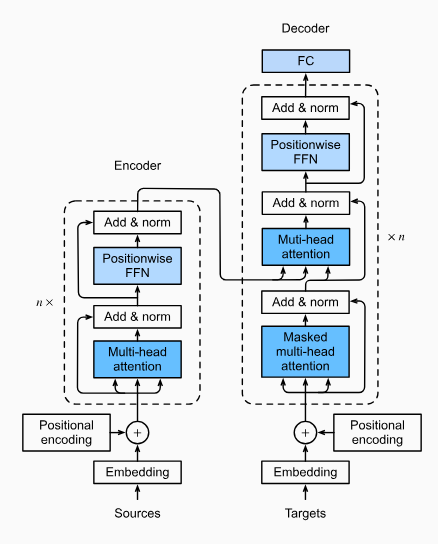

Given the complicated nature of these models, training in this homework will be a little different from other homeworks.<br>
We will employ the following to effectively train the transformer with fewer resources (data and compute power).
<br>
* **Data Complexity and Model Capacity**:  Starting with a CNN-LSTM for input sequences captures temporal dynamics and dependencies early on, simplifying initial learning. This is effective for data with strong temporal or sequential patterns, which LSTMs excel at handling. We will use an already trained model (trained in HW3P2).


* **Gradual (Incremental) Learning**: Starting with a simpler model (like an LSTM) allows the neural network to first learn the basic structures and patterns in the data. When we later introduce more complex mechanisms (like a transformer encoder), the model already has a foundational understanding of the data. This foundation can lead to a smoother and more effective learning process when the complexity of the model increases. In other words, we are using a simple, pretrained LSTM encoder as the basis for our transformer decoder and incrementally adding complexity!

* **Learning Efficiency**: By freezing certain parts of the model during different stages of training, we focus the learning capacity of the network on specific modules, making the training process more efficient. This stepwise unfreezing and training allows different components of the model to adapt gradually, which can be very useful when integrating parts of the model that learn at different rates.

* **Adaptation to Data Characteristics**: This strategy implicitly takes advantage of the data's characteristics by adjusting the model's architecture and training procedure to better suit the data's structure. For instance, if the data contains intricate sequential patterns, starting with an LSTM can harness these patterns effectively. Then, by introducing a transformer encoder, the model can further learn to capture complex, long-range dependencies within the data, something transformers are exceptionally good at.


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

In [12]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [13]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [14]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [15]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [16]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [17]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [18]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [19]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1 (Preliminary Submission)

In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [20]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [21]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)

    def forward(self, x_packed):
        x_padded, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        x_padded, x_lens = self.trunc_reshape(x_padded, x_lens)
        x_packed = pack_padded_sequence(x_padded, x_lens, batch_first=True, enforce_sorted=False)
        output_packed, hidden = self.blstm(x_packed)
        return output_packed

    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2==1:
            x = x[:,:-1,:]
        x = x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2))
        x_lens = (x_lens/2).type(torch.int)
        return x, x_lens

In [22]:
from torch.autograd import Variable

class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        x_unpacked, x_lens = pad_packed_sequence(x, batch_first=True)
        m = x.data.new(x_unpacked.size(0), 1, x_unpacked.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x_unpacked)
        out = mask * x_unpacked
        return pack_padded_sequence(out, lengths=x_lens, batch_first=True, enforce_sorted=False)

In [23]:
class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''

    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.2):
        super(CNN_LSTM_Encoder, self).__init__()

        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(2*input_size),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv1d(2*input_size, 4*input_size, kernel_size=5, stride=1, padding=2),
            torch.nn.BatchNorm1d(4*input_size),
            torch.nn.ReLU(inplace=True)
        )

        self.bilstm = torch.nn.LSTM(input_size=4*input_size, hidden_size=encoder_hidden_size, bidirectional=True, batch_first=True, dropout=enc_dropout)

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout=2*enc_dropout),
            pBLSTM(2*encoder_hidden_size, 2*encoder_hidden_size),
            LockedDropout(dropout=enc_dropout),
        )

        self.permute = Permute()

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)

        x_packed        = pack_padded_sequence(x, x_lens, batch_first= True, enforce_sorted=False)
        x_packed, _     = self.bilstm(x_packed)
        x_packed        = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_packed, batch_first=True)

        return encoder_outputs, encoder_lens

## Transformer Decoder

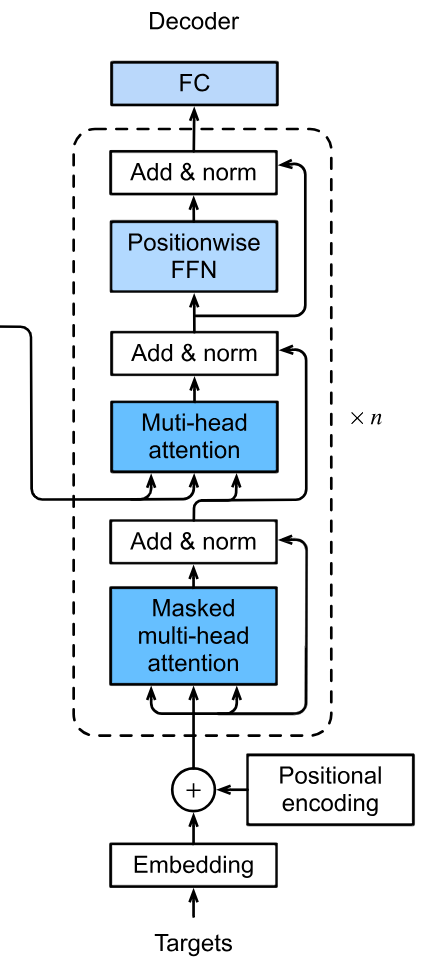

Tips to complete the Decoder below.

* Can you seperate the decoder layers from the whole decoder?
* How many multi-head attention do we have in the figure above.
* How many layer normalizations?
* How do we make the residual connections?

For Forward Method:
* What are the inputs to various multi-head attention modules?
* How do we make the residual connection (do we need dropout)?


In [24]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(n_head = num_heads, d_model = d_model, dropout=dropout)
        self.mha2       = MultiHeadAttention(n_head = num_heads, d_model=d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model=d_model, d_ff=d_ff, dropout=dropout) # this d_ff might be different from dcoder layer

        self.layernorm1 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.layernorm2 = torch.nn.LayerNorm(normalized_shape=d_model)
        self.layernorm3 = torch.nn.LayerNorm(normalized_shape=d_model)

        self.dropout1   = torch.nn.Dropout(p=dropout)
        self.dropout2   = torch.nn.Dropout(p=dropout)
        self.dropout3   = torch.nn.Dropout(p=dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):

        # Masked Multi-Head Attention
        #   (1) apply MHA with the lookahead mask
        ''' TODO '''
        attn_output1, attention_weights1  = self.mha1(q=padded_targets, k=padded_targets, v=padded_targets, mask=slf_attn_mask) # here the padded_targets is (batch, length, d_model)
        # Skip (Residual) Connections
        #   (1) perform dropout on padded attention output
        #   (2) add the true outputs (padded_targets) as a skip connection
        ''' TODO '''
        out1 = padded_targets + self.dropout1(attn_output1)  # or out1 = padded_targets + self.dropout1(attn_output1)
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        normalized1 = self.layernorm1(out1)
        # Masked Multi-Head Attention on Encoder Outputs and Targets
        #   (1) apply MHA with the self-attention mask
        ''' TODO '''
        attn_output2, attention_weights2 = self.mha2(q=normalized1, k=enc_output, v=enc_output, mask=dec_enc_attn_mask) # this a question
        # Skip (Residual) Connections
        #   (1) perform dropout on this second padded attention output
        #   (2) add the output of first MHA block as a skip connection
        ''' TODO '''
        out2 = normalized1 + self.dropout2(attn_output2)
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        normalized2 = self.layernorm2(out2)
        # Feed Forward Network
        #   (1) pass through the FFN
        ''' TODO '''
        FFN_out = self.ffn(normalized2)
        # Skip (Residual) Connections
        #   (1) perform dropout on the output
        #   (2) add the output of second MHA block as a skip connection
        ''' TODO '''
        out3 = self.dropout3(FFN_out) + normalized2
        # apply Layer Normalization onto output of feed-forward network
        ''' TODO '''
        normalized3 = self.layernorm3(out3)
        return normalized3, attention_weights1, attention_weights2

In [25]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding = torch.nn.Embedding(target_vocab_size, d_model, padding_idx=self.PAD_TOKEN)
        self.positional_encoding    = PositionalEncoding(d_model=d_model, max_len=max_seq_length)
        self.final_linear           = torch.nn.Sequential(torch.nn.Linear(d_model, target_vocab_size))
        self.dropout                = torch.nn.Dropout(p=dropout)
        self.layernorm        = torch.nn.LayerNorm(d_model)

    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        ''' TODO '''
        # print(f'The shape for padded_target: {padded_targets.shape}')
        # print(f'The shape for encoder output: {enc_output.shape}')
        # print(f'The shape for encoder input length: {enc_input_lengths.shape}')
        # The shape for padded_target: torch.Size([64, 332])
        # The shape for encoder output: torch.Size([64, 1625, 512])
        # The shape for encoder input length: torch.Size([64])
        padding_mask = create_mask_1(padded_targets, pad_idx=self.PAD_TOKEN)
        # print(f'The shape after padding mask: {padding_mask.shape}')
        """ Create a mask to identify non-padding positions.

        Args:
          padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
          input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
          pad_idx: Optional, the index used for padding tokens.

        Returns:
          A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
        """

        # creating an attention mask for the future subsequences (look-ahead mask)
        ''' TODO '''
        look_ahead_mask =  create_mask_2(padded_targets, pad_idx=self.PAD_TOKEN)
        # print(f'The shape after look ahead mask: {look_ahead_mask.shape}')
        """ Create a mask to prevent positions from attending to subsequent positions.

        Args:
          seq: The input sequence tensor, shape (batch_size, sequence_length).

        Returns:
            A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
        """
        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        ''' TODO '''
        attn_mask = create_mask_3(padded_input=enc_output, input_lengths=enc_input_lengths, expand_length=padded_targets.size(1))
        # print(f'The shape after attn mask: {attn_mask.shape}')
        """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

        Args:
          padded_input: The input tensor with padding, shape (N, Ti, ...).
          input_lengths: The actual lengths of each sequence before padding, shape (N,).
          expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

        Returns:
          An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
        """
        # computing embeddings for the target sequence
        embedding = self.target_embedding.forward(padded_targets)  # the shape is [batch, target_time_length, dmodel]
        # print(f'The shape after embedding: {embedding.shape}')
        # computing Positional Encodings with the embedded targets
        out = self.positional_encoding.forward(embedding)   # positional encoding doesn't change the shape the shape is [batch, target_time_length, dmodel]
        # out = self.dropout(out)
        # print(f'The shape after positional encoding: {out.shape}')
        # passing through decoder layers
        ''' TODO '''
        # i=0
        all_attention_weights = {}
        for i, layer in enumerate(self.dec_layers):
            out, attention_weights1, attention_weights2 = layer(padded_targets = out, enc_output = enc_output, enc_input_lengths = enc_input_lengths, dec_enc_attn_mask = attn_mask, pad_mask = padding_mask, slf_attn_mask = look_ahead_mask)
            all_attention_weights[f'layer_{i+1}_weight1'] = attention_weights1   # I Think shape is (batch_size, target_time_length, target_time_length)
            all_attention_weights[f'layer_{i+1}_weight2'] = attention_weights2   # I Think shape is (batch_size, target_time_length, input time length)
        # linear layer (Final Projection) for next character prediction
        ''' TODO '''
        # out = self.layernorm(out)
        out = self.final_linear(out)
        return out, all_attention_weights


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [26]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)

        self.proj       = torch.nn.Linear(1024, d_model)

        # @NOTE: layernorm here is meant to normalize the dynamic ranges of
        #   the cross attention weights such that the model doesn't bias
        #   itself to only using the cross attention weights and neglect using
        #   the multi-head self attention weights.
        #   This is to enfoce the Language Model constraints in the Decoder.
        #   This is an experimental change -- you may try it if you want.
        self.layernorm  = torch.nn.LayerNorm(d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        # You can experiment with different weight initialization schemes or no initialization here
        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_lens  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Model Setup


In [27]:
torch.cuda.empty_cache()
gc.collect()

0

In [28]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = 27,
dec_num_layers              = config['dec_num_layers'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

enc_dropout                 = config['enc_dropout'],
dec_dropout                 = config['dec_dropout'],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

print(model)

##########
Model Parameters:
 18.678375
##########
SpeechTransformer(
  (encoder): CNN_LSTM_Encoder(
    (embedding): Sequential(
      (0): Conv1d(27, 54, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(54, 108, kernel_size=(5,), stride=(1,), padding=(2,))
      (4): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (bilstm): LSTM(108, 256, batch_first=True, dropout=0.2, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (1): LockedDropout()
      (2): pBLSTM(
        (blstm): LSTM(1024, 512, batch_first=True, bidirectional=True)
      )
      (3): LockedDropout()
    )
    (permute): Permute()
  )
  (proj): Linear(in_features=1024, out_features=512, bias=True)
  (layernorm): LayerNo

### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

Download the weights from here - https://drive.google.com/file/d/1wRcHwCvxksxiPv6WQykOkY9i4bip-ooa/view?usp=sharing

In [29]:
model.encoder.load_state_dict(torch.load("/content/pblstm_fast_training_weights.pth"))

<All keys matched successfully>

## Loss, Optimizer, and Scheduler Definitions

In [30]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [31]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [32]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [33]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [34]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [35]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [36]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [37]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False


# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}_Lr:{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config['learning_rate'])

if USE_WANDB:

    wandb.login(key="b9fec08c02d03c41bdf5fe1f5268589277270fbe", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = "f0bqyz1j"
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24-2",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jianchengsunny (11785-hw3p2). Use `wandb login --relogin` to force relogin


## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 2.7244	 Train Perplexity 15.7842	 Learning Rate 0.000100000


Val:   2%|▏         | 1/43 [00:22<15:39, 22.37s/it, running_distance=210.6562]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  HE HE WHE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   5%|▍         | 2/43 [00:40<13:33, 19.84s/it, running_distance=210.6953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  HE WHE WHE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   7%|▋         | 3/43 [00:59<12:57, 19.43s/it, running_distance=209.4740]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  HE WHE WHE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   9%|▉         | 4/43 [01:20<13:07, 20.20s/it, running_distance=207.8047]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  HE WHE WHE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  HE WHE WHE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE
Levenshtein Distance 207.4563


Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 2.3736	 Train Perplexity 10.7481	 Learning Rate 0.000099901
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 2.2180	 Train Perplexity 9.1956	 Learning Rate 0.000099606


Val:   2%|▏         | 1/43 [00:24<16:53, 24.12s/it, running_distance=203.2500]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND HE SED AND AND AND AND AND AND AND AND THE THE THE THE AND THE THE THE THE THE THE AND THE AND AND AND AND AND THE THE THE THE THE THE AND AND AND AND AND AND THE AND AND AND THE THE THE THE THE AND AND THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   5%|▍         | 2/43 [00:43<14:30, 21.24s/it, running_distance=207.7656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND WHE WAS THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   7%|▋         | 3/43 [01:03<13:55, 20.89s/it, running_distance=206.2344]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND WHE WAS THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND AND AND AND AND AND AND THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE


Val:   9%|▉         | 4/43 [01:25<13:54, 21.39s/it, running_distance=204.2578]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE SED THE THE THE THE THE THE AND AND AN AND AND AND AND THE THE THE THE AND THE AND THE AND AND AND AND AND THE THE THE AND AND THE AND AND AN THE AN AND AND AND AND AND THE THE THE THE THE AND AND THE THE AND AND AND AND THE THE THE THE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE SED THE THE THE THE THE THE THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE AND AND AND AND AND AND THE THE THE THE THE THE AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE
Levenshtein Distance 203.9031


Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 2.1192	 Train Perplexity 8.3265	 Learning Rate 0.000099114
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 2.0504	 Train Perplexity 7.7734	 Learning Rate 0.000098429


Val:   2%|▏         | 1/43 [00:24<17:27, 24.94s/it, running_distance=182.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE THE WAS THE THE SAND THE THE THE THE THE THE THE THE SAND THE SAND THE THE STRE THE SPREARE THE STRE THE THE THE SPREARD THE STRE THE THE SPROME THE SPROME THE THE THE STRE THE THE THE STRE THE STRE THE THE STRE


Val:   5%|▍         | 2/43 [00:46<15:36, 22.85s/it, running_distance=177.0469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE STRE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE SAND THE THE STRE THE THE HE THE STER THE STRE THE THE THE THE THE THE THE THE THE SE


Val:   7%|▋         | 3/43 [01:09<15:24, 23.11s/it, running_distance=176.7240]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE THE WAS THE THE SAND THE THE THE THE THE THE THE THE HE WAS AND THE THE THE STRE THE STRE THE THE THE THE THE THE SHE THE STRE THE THE THE STRE THE SPRES THE THE THE STRE THE THE HE THE STER THE STRE THE THE STRE THE STRE


Val:   9%|▉         | 4/43 [01:36<15:51, 24.39s/it, running_distance=176.6289]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  THE THE WAS THE THE THE WAS THE THE THE THE THE THE THE THE WAS AND THE THE THE THE THE WAS AND THE THE THE THE THE THE THE THE STRE THE THE THE THE THE THE STRE THE THE THE THE THE WAS THE THE THE STRE THE THE THE THE THE THE WAS THE THE SE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE STRE THE THE THE THE THE THE STRE THE THE STRE THE THE THE THE THE THE STATER THE THE THE THE THE THE THE THE SEARE
Levenshtein Distance 177.3375


Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 1.9717	 Train Perplexity 7.1860	 Learning Rate 0.000097553
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 1.8459	 Train Perplexity 6.3480	 Learning Rate 0.000096489


Val:   2%|▏         | 1/43 [00:20<14:30, 20.72s/it, running_distance=72.7188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND STRE AN A THE STRAN AND STRAN THE STO THE STAID THE STAND THE STAND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND AND HE HE HE HE HELD AND AND AND HE HE HE


Val:   5%|▍         | 2/43 [00:32<10:32, 15.42s/it, running_distance=72.2969]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE SHE PRESS HE HAD AND DEST HAD AND AND AND AND AND AND AND AND HAD HAD HAD HAD HAD HAD HAD HAD HAD HAD HAVE


Val:   7%|▋         | 3/43 [00:55<12:32, 18.82s/it, running_distance=78.9323]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE ST A STER AND A SPER AN A PALE AN A PALE AN AN A PAN A PER AND AND AND AND AND AND AND AND HE WAS AND HE WAS


Val:   9%|▉         | 4/43 [01:20<13:52, 21.35s/it, running_distance=82.1602]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  A



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  AND THE AN THE AN TO AN TO SUCH SUCH SUCH SUCH SUCH SUCH SUCH SUCH THE COUNTLY THE COUNTLY THE COULD THE COULD THE COULD THE COULD THE COULD THE COULD THE COULD THE COULD THE
Levenshtein Distance 83.6125


Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 1.4140	 Train Perplexity 4.1585	 Learning Rate 0.000095242
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 1.0638	 Train Perplexity 2.9036	 Learning Rate 0.000093816


Val:   2%|▏         | 1/43 [00:14<10:25, 14.89s/it, running_distance=55.0625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  AND AS STRINK THE NEABLE SOLUND ATRANCE TO HE HOLD HOLD HE HOLD AND UNCE OF AND AND HE AND HE HEAD HEAD HEAD HEAD HEAD HEAD HEAD HEAD HEAD HELS


Val:   5%|▍         | 2/43 [00:35<12:27, 18.23s/it, running_distance=54.0547]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  A SHE PRESSED HAD JENLY AND GRAT WHO HAR WHO HAVE A WHAT AN


Val:   7%|▋         | 3/43 [00:54<12:16, 18.42s/it, running_distance=59.1719]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AND THE SEL EXPROAL EXPROSED HE PALE AND A BUT A BUT A FER AN A FER AN A FEAL A FEAL A FEAVE A FEAL A S AND A SHE WAS


Val:   9%|▉         | 4/43 [01:11<11:47, 18.13s/it, running_distance=62.6641]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHIL RAGE AND A AS LONG A AND A AND A AND AR AND AR FROM ARE FROM ARE FROM ARE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  WHAT THE ADD INTO INTO A STURE TO SUFFICION WHAT A WAND WHIT A WAN WHO A WAN WHO A WAN WHO A WHEN WHO AN WHO AN WHO AN WHO AND WHO AN WHO AND WHO AN WHO 
Levenshtein Distance 63.5187


Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.9032	 Train Perplexity 2.4695	 Learning Rate 0.000092217
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.8078	 Train Perplexity 2.2442	 Learning Rate 0.000090452


Val:   2%|▏         | 1/43 [00:11<08:16, 11.83s/it, running_distance=50.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRING THE NABLE SOLON IN A TRANCE TO HE HOLD HOLD HOLD HE HOLD AND UNCE A AND AND AND HE AND HE AND HE HEAD HEAD HEAD HEAD HEAL


Val:   5%|▍         | 2/43 [00:19<06:20,  9.27s/it, running_distance=48.0625]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  A SHE PRESSED HAD GENLY AND GRAD WHO WHO HA WARD WHO HAP


Val:   7%|▋         | 3/43 [00:32<07:21, 11.04s/it, running_distance=52.8958]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  A THE SELL EXPOSED EXPOSED HIM TO THE PEA BE A BE A BE A BE A BE A FEW THE BUT A FEEL GO A S AGE HE WAS AGE HE WAS AND EVE AND EVE


Val:   9%|▉         | 4/43 [00:45<07:37, 11.73s/it, running_distance=56.2695]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHO RANGE WAS LAST LONGER A AND A AND A AND ARE FROM ARE FROM ARE AN



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  A PUT THE ADD INTO AS TO STUP IN WITH SUFFICION WHO GOVER WHO GO WH A WHO WHO WAY WHO WHO A WHO A WAN THE WO TO COOR
Levenshtein Distance 57.0344


Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.7434	 Train Perplexity 2.1040	 Learning Rate 0.000088527
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.6931	 Train Perplexity 2.0005	 Learning Rate 0.000086450


Val:   2%|▏         | 1/43 [00:15<10:42, 15.29s/it, running_distance=48.7031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRINK TRINK THE NABLE SOLON IN IN IN A TRANCE TO HOLD HIS BODY STIF AND UNCE A AND AND HE AND HE AND HE HEAD HEAD HEAL


Val:   5%|▍         | 2/43 [00:22<07:16, 10.65s/it, running_distance=45.3906]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  A SHE PRESSED HAD GENLY AND GRAD WHO WHO WHO HAPPY THE AN


Val:   7%|▋         | 3/43 [00:42<09:47, 14.70s/it, running_distance=50.0208]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  A THE SEEL OF CARRAL EXPOSED HIM TO THE PEA BUT A BUT A BUT A BUT THE A FEEL TH A FEEL GO A SURE A HE WAS AND A SHE WAS


Val:   9%|▉         | 4/43 [00:55<09:14, 14.21s/it, running_distance=53.1562]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WITER A LONGER A AND A AND A SKEEP MORE FROM ARE FROM ARE FROM AN



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  A PUT THE ADD INTO A STUPIN WITH SUFFICION WITH S SUF WHO GO GOVE A WHO WAY WHO A WHO A WHEN WHO AN WHO AND WHO A
Levenshtein Distance 53.8656


Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.6547	 Train Perplexity 1.9251	 Learning Rate 0.000084229
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.6230	 Train Perplexity 1.8651	 Learning Rate 0.000081873


Val:   2%|▏         | 1/43 [00:11<08:22, 11.96s/it, running_distance=44.8125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRINGTH THE NABLE SOLON IN IN IN ATRANCE TO HOLD HOLD HIS BODY STIF AND UNCE O AND A AND HE AND HE AND HE HEAD HEAD HEAL


Val:   5%|▍         | 2/43 [00:19<06:25,  9.41s/it, running_distance=41.3828]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENLY AND GRAT WO WHO HAPPY THEN


Val:   7%|▋         | 3/43 [00:37<08:51, 13.29s/it, running_distance=46.4271]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEEL OF CARRAL EXPOSED HIM TO THE PEND THE PER TH GE A BO TH THE S O THE SUPERSIS AGE HE WAS AGE HE WAS AGE HE WAS AN


Val:   9%|▉         | 4/43 [00:51<08:43, 13.42s/it, running_distance=49.6680]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WHITER A LONGER AND AND ASKEP MORE AND ARE FROM IN



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  HE PUT THE ADDER INTO STUPIN WITH SUFFICIENT WATH S A WO GO HER WH A WHO WHO QUIT WO WHEN TO WHO TO QUE
Levenshtein Distance 50.5094


Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.5972	 Train Perplexity 1.8175	 Learning Rate 0.000079391
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 0.5722	 Train Perplexity 1.7726	 Learning Rate 0.000076794


Val:   2%|▏         | 1/43 [00:12<08:43, 12.46s/it, running_distance=42.3594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRINGTH THE NABLE SOLON IN IN IN IN TRANCE TO HOLD HIS BODY STIF AND UNCE TH AND UNCE A THE HEAD AND HE HEAD HEAD HEAL


Val:   5%|▍         | 2/43 [00:20<06:42,  9.82s/it, running_distance=38.9141]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENLY AND GRAD WH WORD WHO HAPPY THAN


Val:   7%|▋         | 3/43 [00:34<07:44, 11.60s/it, running_distance=43.6198]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEEL OF CARRAL EXPOSED HIM TO THE PEND HIS OF THE JULY A BUT TH A FEEL TH A FEEL GO A SUPERSISIS AGE HE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:48<08:07, 12.51s/it, running_distance=46.8633]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WHATER LAST LONGER AND AND ISKEP MORE FROM INTE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  A PUT THE AT TO STUPIN WITH SUFFICIENT WITH SUFFICIE WHO A WHO GEN WH A WHEN TH WHEN TO WHEN TAY WHEN TAKE AN WH TO TO TO COUL
Levenshtein Distance 47.6219


Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 0.5531	 Train Perplexity 1.7390	 Learning Rate 0.000074090
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 0.5341	 Train Perplexity 1.7063	 Learning Rate 0.000071292


Val:   2%|▏         | 1/43 [00:11<08:03, 11.51s/it, running_distance=40.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRINGTH THE NABLE SOLON IN IN IN ATTRANCE TO HOLD HOLD HIS BODY AND UNCE THE AND UNCE THE AND HE HEAD AND HEAL


Val:   5%|▍         | 2/43 [00:18<06:13,  9.10s/it, running_distance=37.1094]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATI WORD WO HAPPY THAN


Val:   7%|▋         | 3/43 [00:31<07:08, 10.70s/it, running_distance=41.7865]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEEL OF CARRAL EXPOSED HIM TO THE PEND HIS OF THE JULY A BUT THAT A FEEB GUT IN FEEBRMENT A SUPERSIS AGE HE WAS THE WAS AN


Val:   9%|▉         | 4/43 [00:44<07:35, 11.68s/it, running_distance=45.2070]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHATER LAST LONGER AND AND ISKEEP MORE AND ARE FROM ANT



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE AT THE ENTO ASTUPIN WITH SUFFICIENT WATH SUFF A WHO GO A WHO GEN WHO A QUITE WHEN TAK IT OW TO TO AND WHEN TAKE AND WHO A
Levenshtein Distance 45.9656


Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 0.5155	 Train Perplexity 1.6748	 Learning Rate 0.000068409
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 0.4886	 Train Perplexity 1.6305	 Learning Rate 0.000065454


Val:   2%|▏         | 1/43 [00:11<07:47, 11.14s/it, running_distance=39.0156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRINGTH THE NABLE SOLON IN IN ATTRANCE TO HOLD HOLD HIS BODY AND UNSUPPORTED EXCE TH OPOINT THE HEAD AND HELE


Val:   5%|▍         | 2/43 [00:18<06:06,  8.95s/it, running_distance=34.9375]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATI WARD YOU HAPPY THAN


Val:   7%|▋         | 3/43 [00:30<06:50, 10.25s/it, running_distance=39.5156]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEEL OF CARRAL EXPOSED HIM TO THE PENDLED THE JULY AN TH FEE THE FEEB THAT IN FEEBRMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:45<07:48, 12.00s/it, running_distance=43.0469]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DISCHEPED MORE AND ENTENSITY



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  HE PUT THE ADDER INTO ASTUPIN WITH SUFFICIENT WANT WATH A GOVE WH A GEN WHO WHEN TO WH TAKE AN WHEN TAKE AN WHEN TAKE
Levenshtein Distance 43.6156


Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 0.4640	 Train Perplexity 1.5908	 Learning Rate 0.000062438
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 0.4442	 Train Perplexity 1.5595	 Learning Rate 0.000059373


Val:   2%|▏         | 1/43 [00:12<08:27, 12.09s/it, running_distance=37.5156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  A STRINGTH THE NABLE SOMON IN IN TRANCE TO HOLD HOLD HIS BODY STIF AND UNCE THE SEPT THE HEAD AND HEAL


Val:   5%|▍         | 2/43 [00:20<06:48,  9.96s/it, running_distance=33.0781]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATI WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:33<07:23, 11.10s/it, running_distance=37.4740]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARRAL EXPOSED HIM TO THE PENDLED HIS OF THE JULY A DO TH A FEEBLE GO A FEEBRMENT AND A SUPERSISE AGE HE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:48<08:17, 12.76s/it, running_distance=40.7539]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND AND SKEEP MORE AND ENTENSITY



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  HE PUT THE ADDER INTO ASTUPIN WITH SUFFICIENT WANTER TO COVER WH A GEN WH A QUITE A QUITE AN WHEN TAKE AN WHEN TAKE AND WHEN TAKE
Levenshtein Distance 41.6000


Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 0.4289	 Train Perplexity 1.5359	 Learning Rate 0.000056271
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 0.4150	 Train Perplexity 1.5147	 Learning Rate 0.000053144


Val:   2%|▏         | 1/43 [00:11<08:10, 11.69s/it, running_distance=34.8594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRINGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HEAL


Val:   5%|▍         | 2/43 [00:20<06:37,  9.70s/it, running_distance=30.7656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATI WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:31<07:05, 10.65s/it, running_distance=35.4740]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARRAL EXPOSED HIM TO THE PENDLED THE JULY AN A FEW TH A FEEB GUE A FEEBRMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS AN


Val:   9%|▉         | 4/43 [00:47<08:08, 12.52s/it, running_distance=39.1016]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND AND SKEEP MORE AT MORE FROM INTE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  HE PUT THE ADDER INTO ASTUPIN WITH SUFFICIENT WANTER TO GOVER A WH A GENT WHEN TO A QUITE A WHEN TAKE AN WHEN TAKE AND WHO TO AN
Levenshtein Distance 39.8250


Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 0.4050	 Train Perplexity 1.4997	 Learning Rate 0.000050005
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 0.3942	 Train Perplexity 1.4835	 Learning Rate 0.000046866


Val:   2%|▏         | 1/43 [00:10<07:25, 10.61s/it, running_distance=34.3906]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRINGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELE


Val:   5%|▍         | 2/43 [00:19<06:25,  9.40s/it, running_distance=30.2188]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATI WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:29<06:40, 10.02s/it, running_distance=35.0781]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARRAL EXPOSED HIM TO THE PENDLED THE JULY AN A FEW TH GE A FEEBLE GOVERNMENT AND A SUIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:44<07:40, 11.80s/it, running_distance=38.2734]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENT



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ATTER INTO A STUE PIN WITH SUFFICIENT WATE WANT WO GER A WH A GEN WHO A WHEN TAK A WHEN TAKE AN WHEN TAKE AND WHO TO TO TO TO TO TO TO TO AN
Levenshtein Distance 39.0750


Saved epoch model
Saved best training model

Epoch 28/50



Epoch 28/50: 
Train Loss 0.3847	 Train Perplexity 1.4694	 Learning Rate 0.000043739
Saved epoch model
Saved best training model

Epoch 29/50



Epoch 29/50: 
Train Loss 0.3780	 Train Perplexity 1.4596	 Learning Rate 0.000040637


Val:   2%|▏         | 1/43 [00:11<07:54, 11.30s/it, running_distance=34.9531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRINGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELE


Val:   5%|▍         | 2/43 [00:20<06:42,  9.82s/it, running_distance=30.0469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:31<06:58, 10.46s/it, running_distance=34.7031]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENDLED THE JULY AN A FEEB A FEEB GOVERNMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS THE


Val:   9%|▉         | 4/43 [00:47<08:16, 12.74s/it, running_distance=38.2266]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND AND ISCHEPED MORE FROM INTENSITY



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STUPIN WITH SUFFICIENT WANTER TO COVER WH A GENT A WHO QUITE DO WH TAKE AN WHEN TAKE AN WHEN TAKE
Levenshtein Distance 38.6437


Saved epoch model
Saved best training model

Epoch 30/50



Epoch 30/50: 
Train Loss 0.3716	 Train Perplexity 1.4502	 Learning Rate 0.000037572
Saved epoch model
Saved best training model

Epoch 31/50



Epoch 31/50: 
Train Loss 0.3652	 Train Perplexity 1.4410	 Learning Rate 0.000034556


Val:   2%|▏         | 1/43 [00:12<08:44, 12.49s/it, running_distance=32.9375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRINGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELD


Val:   5%|▍         | 2/43 [00:20<06:53, 10.08s/it, running_distance=28.9688]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:32<07:05, 10.63s/it, running_distance=33.8021]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARRIL EXPOSED HIM TO THE PENDLED HE JULY AN A FEW THAT A FEEBLE GO VERNMENT AND A SUPERSISH AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:46<07:58, 12.28s/it, running_distance=36.9297]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND AND ESCEPT MORE AT MORE FROM INTE



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STUPIN WITH SUFFICIENT WANTER TO COVER A WH A GENT WHEN TAK WHEN TAK IT OW AND WHEN TAKE AND WHEN TAKE
Levenshtein Distance 37.4062


Saved epoch model
Saved best training model

Epoch 32/50



Epoch 32/50: 
Train Loss 0.3601	 Train Perplexity 1.4337	 Learning Rate 0.000031601
Saved epoch model
Saved best training model

Epoch 33/50



Epoch 33/50: 
Train Loss 0.3564	 Train Perplexity 1.4284	 Learning Rate 0.000028718


Val:   2%|▏         | 1/43 [00:11<08:23, 11.98s/it, running_distance=34.0156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELE


Val:   5%|▍         | 2/43 [00:20<06:46,  9.91s/it, running_distance=29.7812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:33<07:33, 11.34s/it, running_distance=33.8958]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENELT THE JULY AN THE FEEB THAT IN FEEBLE GOVERNMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:46<07:41, 11.83s/it, running_distance=37.5781]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTEN



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STUE PIN WITH SUFFICIENT WANTER TO A GO A WHO GEN A WH TAKE DO WH TO QUITE AN A WHEN TAKE AND AW AND TO TO TO AN
Levenshtein Distance 38.0938


Saved epoch model
Saved best training model

Epoch 34/50



Epoch 34/50: 
Train Loss 0.3506	 Train Perplexity 1.4201	 Learning Rate 0.000025920
Saved epoch model
Saved best training model

Epoch 35/50



Epoch 35/50: 
Train Loss 0.3474	 Train Perplexity 1.4156	 Learning Rate 0.000023216


Val:   2%|▏         | 1/43 [00:11<07:54, 11.29s/it, running_distance=33.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:19<06:30,  9.53s/it, running_distance=28.9062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:31<06:59, 10.49s/it, running_distance=33.7708]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENDLED HIS OF THE JULY A B A FEEBLE GO VERMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:44<07:28, 11.50s/it, running_distance=37.0625]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND AND ESCEPED MORE AT MORE FROM INTEN



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STUE PIN WITH SUFFICIENT WANTER TO COVER A WH A GENT A WHO A QUITE DO A WHEN TAKE AN WHEN TAKE AND AWAR
Levenshtein Distance 37.4656


Saved epoch model
Saved best training model

Epoch 36/50



Epoch 36/50: 
Train Loss 0.3447	 Train Perplexity 1.4118	 Learning Rate 0.000020619
Saved epoch model
Saved best training model

Epoch 37/50



Epoch 37/50: 
Train Loss 0.3412	 Train Perplexity 1.4068	 Learning Rate 0.000018137


Val:   2%|▏         | 1/43 [00:13<09:39, 13.80s/it, running_distance=33.4062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELE


Val:   5%|▍         | 2/43 [00:22<07:27, 10.91s/it, running_distance=29.1250]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:34<07:31, 11.28s/it, running_distance=33.5885]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARRIL EXPOSED HIM TO THE PENAL THE JULY IN LAW A VE A FEEBLE GO VERNMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS AN


Val:   9%|▉         | 4/43 [00:48<07:57, 12.25s/it, running_distance=36.9102]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENT



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO A GO A WHO GENT A WHO A QUITE DO A WHEN TAKE IT OUR
Levenshtein Distance 37.3062


Saved epoch model
Saved best training model

Epoch 38/50



Epoch 38/50: 
Train Loss 0.3390	 Train Perplexity 1.4038	 Learning Rate 0.000015781
Saved epoch model
Saved best training model

Epoch 39/50



Epoch 39/50: 
Train Loss 0.3366	 Train Perplexity 1.4004	 Learning Rate 0.000013560


Val:   2%|▏         | 1/43 [00:11<07:59, 11.42s/it, running_distance=32.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRINGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:20<06:43,  9.83s/it, running_distance=28.3203]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:31<07:08, 10.70s/it, running_distance=32.8385]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARRIL EXPOSED HIM TO THE PENALT THE JULY IN A FEW THAT A FEEBLE GOVERNMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:47<08:10, 12.57s/it, running_distance=36.1758]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENS



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STUE PIN WITH SUFFICIENT WANTER TO A GOVER A WH A GENT WHEN TAK IT DO WH TO TO TO TO COUL
Levenshtein Distance 36.8531


Saved epoch model
Saved best training model

Epoch 40/50



Epoch 40/50: 
Train Loss 0.3348	 Train Perplexity 1.3979	 Learning Rate 0.000011483
Saved epoch model
Saved best training model

Epoch 41/50



Epoch 41/50: 
Train Loss 0.3322	 Train Perplexity 1.3942	 Learning Rate 0.000009558


Val:   2%|▏         | 1/43 [00:13<09:27, 13.51s/it, running_distance=32.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:22<07:12, 10.56s/it, running_distance=28.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:33<07:23, 11.10s/it, running_distance=33.0104]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENAL THE PENAL A VE A FEEB A FEEBLE GO VERMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:48<08:06, 12.48s/it, running_distance=36.3633]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENS



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO A GO A WHO GENT A WHO A QUITE DO A WHEN TAKE IT OUT
Levenshtein Distance 36.6781


Saved epoch model
Saved best training model

Epoch 42/50



Epoch 42/50: 
Train Loss 0.3307	 Train Perplexity 1.3922	 Learning Rate 0.000007793
Saved epoch model
Saved best training model

Epoch 43/50



Epoch 43/50: 
Train Loss 0.3298	 Train Perplexity 1.3909	 Learning Rate 0.000006194


Val:   2%|▏         | 1/43 [00:12<08:39, 12.38s/it, running_distance=32.3125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:21<06:57, 10.18s/it, running_distance=27.9844]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:32<07:15, 10.89s/it, running_distance=32.4427]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENAL THE JULY AN A FEW THAT A FEEBLE GO VERMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:48<08:21, 12.86s/it, running_distance=35.4766]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENS



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO GO A WHO GENT A WHO GEN WHEN TAKE A WHEN TAKE AN WHEN TAKE AND WHO TO AN
Levenshtein Distance 35.9719


Saved epoch model
Saved best training model

Epoch 44/50



Epoch 44/50: 
Train Loss 0.3290	 Train Perplexity 1.3898	 Learning Rate 0.000004768
Saved epoch model
Saved best training model

Epoch 45/50



Epoch 45/50: 
Train Loss 0.3293	 Train Perplexity 1.3903	 Learning Rate 0.000003521


Val:   2%|▏         | 1/43 [00:11<08:17, 11.84s/it, running_distance=32.2969]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:20<06:49, 10.00s/it, running_distance=28.3594]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:33<07:25, 11.13s/it, running_distance=32.4844]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENAL THE JULY AN A FEEB A FEEB GUT IN A FEEBLE GOVERNMENT AND A SUPER SIS AGE HE WAS THE WAS THE


Val:   9%|▉         | 4/43 [00:48<08:22, 12.87s/it, running_distance=35.5000]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENS



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO A GO A GENTLY TO QUITE DO WH TAKE A WHEN TAKE IT OUT
Levenshtein Distance 35.9656


Saved epoch model

Epoch 46/50



Epoch 46/50: 
Train Loss 0.3278	 Train Perplexity 1.3881	 Learning Rate 0.000002457
Saved epoch model
Saved best training model

Epoch 47/50



Epoch 47/50: 
Train Loss 0.3267	 Train Perplexity 1.3865	 Learning Rate 0.000001581


Val:   2%|▏         | 1/43 [00:11<08:13, 11.76s/it, running_distance=32.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELE


Val:   5%|▍         | 2/43 [00:20<06:48,  9.96s/it, running_distance=28.1953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:32<07:23, 11.09s/it, running_distance=32.4375]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENAL THE JULY AN A FEW THAT A FEEBLE GO VERMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:48<08:16, 12.72s/it, running_distance=35.7500]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENT



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO A GO A WHO GENT A WHO A QUITE DO A WHEN TAKE IT OUT
Levenshtein Distance 36.0688


Saved epoch model
Saved best training model

Epoch 48/50



Epoch 48/50: 
Train Loss 0.3274	 Train Perplexity 1.3876	 Learning Rate 0.000000896
Saved epoch model

Epoch 49/50



Epoch 49/50: 
Train Loss 0.3273	 Train Perplexity 1.3875	 Learning Rate 0.000000404


Val:   2%|▏         | 1/43 [00:12<08:48, 12.57s/it, running_distance=32.4531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  TH STRENGTH THE NABLE SOME IN IN TRANCE TO HOLD HIS BODY STIF AND UNSUPPORTED EXCEPT THE HEAD AND HELES


Val:   5%|▍         | 2/43 [00:21<07:00, 10.26s/it, running_distance=28.2812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATIT WORD YOU HAPPY THEN AN


Val:   7%|▋         | 3/43 [00:33<07:31, 11.28s/it, running_distance=32.4219]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE SEAL OF CARREL EXPOSED HIM TO THE PENAL THE JULY IN LAW A TH A FEEBLE GO VERNMENT AND A SUPERSIS AGE HE WAS THE WAS THE WAS THE WAS


Val:   9%|▉         | 4/43 [00:48<08:21, 12.85s/it, running_distance=35.5625]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RANGE WATER LAST LONGER AND DESCEPED MORE AT MORE FROM INTENS



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  H PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO A GO A WHO GENT A WHO A QUITE DO A WHEN TAKE IT OUR
Levenshtein Distance 35.9344


Saved epoch model

Epoch 50/50



Epoch 50/50: 
Train Loss 0.3271	 Train Perplexity 1.3872	 Learning Rate 0.000000109
Saved epoch model


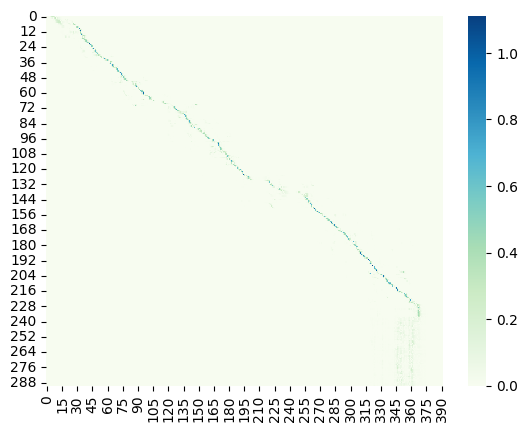

In [ ]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-.pth'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)
epoch_model_path                        = os.path.join(checkpoint_root, checkpoint_last_epoch_filename)
if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    # checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)
    model, optimizer, scheduler, epoch, metric = load_model(epoch_model_path, model, metric= "train_loss", optimizer= optimizer, scheduler= scheduler)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = epoch

    print("Resuming from epoch {}".format(epoch+1))
    print("Epochs left: ", config['epochs']-epoch)
    print("Optimizer: \n", optimizer)
    print("Scheduler: \n", scheduler.state_dict())
    print("metric: \n", metric)
    scheduler.T_max = 75
    print("Scheduler: \n", scheduler.state_dict())

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.09f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder_cross, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
valid_actual_distance = validate_full(model, val_loader)

## Testing

In [ ]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [37:54<00:00, 66.53s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f test.csv -m "HW4P2 Preliminary Submission"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 532, in competition_submit
    url_result['createUrl'], quiet)
KeyError: 'createUrl'


In [ ]:
# TODO Sumbit predictions to Kaggle

# PART #2 Full Transformer (Encoder-Decoder)

Using an LSTM encoder helps to capture some dependencies in the input sequence which helps the transformer decoder to decode. However, we can do more than that. The transformer encoder plays a crucial role by processing the input sequence into a high-dimensional space, capturing complex relationships between elements. It uses self-attention to understand the context around each feature, enabling the model to grasp subtle nuances and dependencies, crucial for our speech recognition task and improving performance.

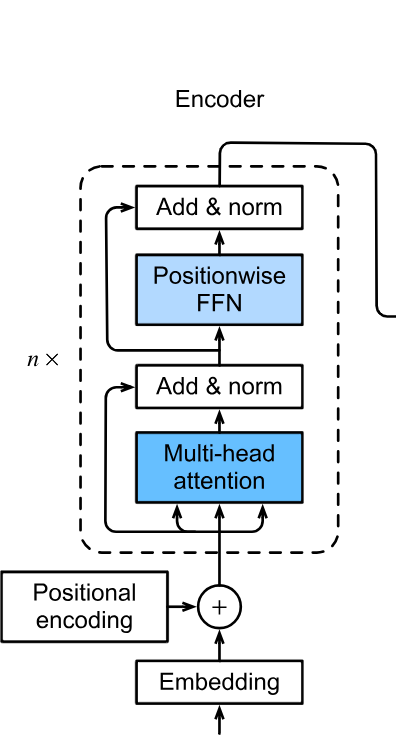

Tips in completing this section

* We will use the LSTM Encoder as input embedding.
* How many multi-head attention modules do we have.
* Can you seperate the encoder layer from the whole encoder architecture ?
* How do  we implement skip  connections
* How many layer norms do we have ?

## Transformer Encoder

In [39]:
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha        = MultiHeadAttention(n_head=num_heads, d_model=d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)

    def forward(self, inp):  # shape: (batch_size, time_length, d_model)

        # Multi-Head Attention
        #   (1) perform Multi-Head Attention on inp
        ''' TODO '''
        # print(f'The shape of inp is {inp.shape}')
        attn_output, _ = self.mha(q=inp, k=inp, v=inp)
        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the input as a skip connection
        ''' TODO '''
        out1 = self.dropout1(attn_output) + inp
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        layernorm_out1 = self.layernorm1(out1)
        # Feed Forward Network
        #   (1) apply feed forward layer
        ''' TODO '''
        ffn_out = self.ffn(layernorm_out1)
        # Skip (Residual) Connection
        #   (1) perform dropout
        #   (2) add the output of the first layernorm as a skip connection
        ''' TODO '''
        out2 = self.dropout2(ffn_out) + layernorm_out1
        # Layer Normalization
        #   (1) call layernorm on this resulting value
        ''' TODO '''
        layernorm_out2 = self.layernorm2(out2)  # shape: (batch_size, time_length, d_ff)
        return layernorm_out2

In [40]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, num_layers, d_model, num_heads, d_ff, mfcc_max_seq_length, dropout=0.1):
        super(Encoder, self).__init__()

        # @TODO: fill in the blanks appropriately (given the modules above and P1 setup)
        self.embedding      = CNN_LSTM_Encoder(input_size=input_dim, encoder_hidden_size=256, enc_dropout=dropout)
        self.projection     = torch.nn.Linear(1024, d_model)
        self.positional_encoding    = PositionalEncoding(d_model=d_model, max_len=mfcc_max_seq_length)

        # concatenating all num_layers EncoderLayer blocks
        self.enc_layers     = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.dropout        = torch.nn.Dropout(p=dropout)
        self.layernorm      = torch.nn.LayerNorm(d_model)

    def forward(self, x, input_lengths):

        # apply the CNN-LSTM Encoder (embedding)
        ''' TODO '''
        # print(f'The shape before embedding is {x.shape}')
        embedding_out, embedding_out_length = self.embedding(x, input_lengths)  # shape: (batch_size, time_length, features)
        # print(f'The shape of embedding_out is {embedding_out.shape}')
        # adding projection layer to change dimension of encoder_outputs to match d_model
        ''' TODO '''
        projection_out = self.projection(embedding_out)       # shape: (batch_size, time_length, d_model)
        # print(f'The shape of projection_out is {projection_out.shape}')
        # apply Positional Encoding on these extracted features
        ''' TODO '''
        position_out = self.positional_encoding(projection_out)   # shape: (batch_size, time_length, d_model)
        # print(f'The shape of position_out is {position_out.shape}')
        # apply dropout as regularization technique
        ''' TODO '''
        out = self.dropout(position_out) #   shape: (batch_size, time_length, d_model)
        # print(f'The shape of dropout is {out.shape}')
        # passing inputs through Transformer Encoder blocks
        ''' TODO '''
        for i, layer in enumerate(self.enc_layers):
            out = layer(out)     # shape: (batch_size, time_length, d_ff)
            # all_attention_weights[f'layer_{i+1}_weight1'] = attention_weights1   # I Think shape is (batch_size, target_time_length, target_time_length)
            # all_attention_weights[f'layer_{i+1}_weight2'] = attention_weights2   # I Think shape is (batch_size, target_time_length, input time length)
        return out, embedding_out_length

In [41]:
class FullTransformer(torch.nn.Module):
    def __init__(self, input_dim, enc_num_layers, dec_num_layers, enc_num_heads, dec_num_heads,
                 d_model, d_ff, target_vocab_size, eos_token, sos_token,
                 pad_token, dropout=0.1, trans_max_seq_length=550, mfcc_max_seq_length=3260):

        super(FullTransformer, self).__init__()

        self.encoder = Encoder(input_dim, enc_num_layers, d_model, enc_num_heads, d_ff,
                               mfcc_max_seq_length,  dropout)

        self.decoder = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                               dropout, target_vocab_size, trans_max_seq_length, eos_token, sos_token, pad_token)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):
        # passing through Encoder
        encoder_output, encoder_lens = self.encoder(padded_input, input_lengths)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_lens)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterance at a time """

        encoder_outputs, encoder_lens = self.encoder(inp, inp_len)
        out = self.decoder.recognize_greedy_search(encoder_outputs, encoder_lens)

        return out

## Full Model Setup

In [42]:
full_model = FullTransformer(
input_dim                   = 27,
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)



para_full = num_parameters(full_model)
print("#"*10)
print(f"Model Parameters:\n {para_full}")
print("#"*10)

print(full_model)

##########
Model Parameters:
 18.678375
##########
FullTransformer(
  (encoder): Encoder(
    (embedding): CNN_LSTM_Encoder(
      (embedding): Sequential(
        (0): Conv1d(27, 54, kernel_size=(5,), stride=(1,), padding=(2,))
        (1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(54, 108, kernel_size=(5,), stride=(1,), padding=(2,))
        (4): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (bilstm): LSTM(108, 256, batch_first=True, dropout=0.2, bidirectional=True)
      (pBLSTMs): Sequential(
        (0): pBLSTM(
          (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
        )
        (1): LockedDropout()
        (2): pBLSTM(
          (blstm): LSTM(1024, 512, batch_first=True, bidirectional=True)
        )
        (3): LockedDropout()
      )
      (permute): Permute()
    )
    (projection): Li

In [ ]:
### Load your best P1 model checkpoint
model.load_state_dict(torch.load('/content/checkpoints-basic-transformer/checkpoint-best-loss-model.pth')['model_state_dict'])

<All keys matched successfully>

Freezing model weights except for transformer encoder layers. This is like an initialization strategy so that the encoder learns the range of values required by the decoder. After about 3 epochs when this initialzation is done, unfreeze weights of the entire model and let it train.




In [ ]:
### Copy weights from P1 model to full model
### Freeze the weights of full transformer input embedding, linear projection, and decoder

full_model.encoder.embedding.load_state_dict(model.encoder.state_dict())
for param in full_model.encoder.embedding.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.encoder.projection.load_state_dict(model.proj.state_dict())
for param in full_model.encoder.projection.parameters():
    param.requires_grad = False # TODO make it non-trainable

full_model.decoder.load_state_dict(model.decoder.state_dict())
for param in full_model.decoder.parameters():
    param.requires_grad = False # TODO make it non-trainable

## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

## WandB

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False


# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}_Lr:{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config['learning_rate'])

if USE_WANDB:

    wandb.login(key="b9fec08c02d03c41bdf5fe1f5268589277270fbe", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = "f0bqyz1j"
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24-2",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(full_model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


learning_rate,█▇▅▁
train_loss,█▂▁▁
train_perplexity,█▂▁▁
val_distance,█▁
learning_rate,0.0001
train_loss,0.48329
train_perplexity,1.62174
val_distance,19.77188


## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 0.4382	 Train Perplexity 1.5506	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:19<13:52, 19.81s/it, running_distance=19.0469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOME IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEALS


Val:   5%|▍         | 2/43 [01:27<32:46, 47.96s/it, running_distance=18.4062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:54<25:32, 38.30s/it, running_distance=17.8490]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPPERSISHES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAYS


Val:   9%|▉         | 4/43 [03:11<34:48, 53.55s/it, running_distance=20.3828]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STUE PIN WITH SUFFICIENT WANDER TO COVERT LED ITS DUE GENTLY TO QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 20.2188


Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 0.3978	 Train Perplexity 1.4889	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 0.3765	 Train Perplexity 1.4574	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:20<14:22, 20.54s/it, running_distance=17.3750]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH OF A NABLE SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:28<32:56, 48.20s/it, running_distance=17.2188]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<27:36, 41.42s/it, running_distance=16.9323]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENDLED HIS OF THE JEWLY IN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPPERSISHES AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAYS


Val:   9%|▉         | 4/43 [03:18<36:02, 55.44s/it, running_distance=20.8438]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANTER TO COVERT LED ITS DUEGENTLY TO QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 22.5562


Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 0.3607	 Train Perplexity 1.4346	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 0.3469	 Train Perplexity 1.4149	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:19<55:24, 79.16s/it, running_distance=31.4219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRINGTH THE NABLE SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [02:26<49:19, 72.19s/it, running_distance=23.9922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:56<35:18, 52.97s/it, running_distance=21.2344]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENDLED HIS OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAYS


Val:   9%|▉         | 4/43 [03:20<26:55, 41.44s/it, running_distance=21.2852]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STUE PIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUENLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 20.8781


Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 0.3356	 Train Perplexity 1.3989	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 0.3234	 Train Perplexity 1.3820	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:22<15:54, 22.73s/it, running_distance=16.5000]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:38<12:33, 18.38s/it, running_distance=12.5938]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<15:27, 23.19s/it, running_distance=12.8125]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENDLED HIS OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:23<28:49, 44.34s/it, running_distance=15.9062]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND DESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LED ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.4500


Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 0.3144	 Train Perplexity 1.3696	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 0.3047	 Train Perplexity 1.3565	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:20<14:24, 20.58s/it, running_distance=16.9375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:35<11:55, 17.46s/it, running_distance=13.1172]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:01<14:00, 21.01s/it, running_distance=13.4167]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPPERSISH'S AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:17<27:57, 43.00s/it, running_distance=17.7109]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANDER TO COVERT LED ITS DUGENTLY TILL QUITE DONE WHEN TAKE IT OWED TO COOL
Levenshtein Distance 18.3281


Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.2965	 Train Perplexity 1.3453	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.2894	 Train Perplexity 1.3358	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:20<14:40, 20.95s/it, running_distance=16.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH THE NABLE SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:28<33:02, 48.34s/it, running_distance=16.4844]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:57<26:23, 39.58s/it, running_distance=15.2344]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAYS


Val:   9%|▉         | 4/43 [03:14<35:12, 54.18s/it, running_distance=17.2148]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANDER TO COVERT LED ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.7375


Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.2826	 Train Perplexity 1.3268	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.2757	 Train Perplexity 1.3176	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:19<13:52, 19.81s/it, running_distance=16.3594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:35<11:43, 17.16s/it, running_distance=12.5625]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY AND GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [00:58<13:28, 20.22s/it, running_distance=12.8125]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:15<27:41, 42.61s/it, running_distance=16.9219]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANDER TO COVERT LED ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.3781


Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.2695	 Train Perplexity 1.3095	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.2642	 Train Perplexity 1.3026	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:21<15:01, 21.47s/it, running_distance=15.4531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:29<33:14, 48.65s/it, running_distance=14.9922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:56<26:05, 39.15s/it, running_distance=14.0833]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:23<22:04, 33.96s/it, running_distance=14.9062]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.1469


Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.2594	 Train Perplexity 1.2963	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 0.2540	 Train Perplexity 1.2894	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:20<14:40, 20.96s/it, running_distance=15.5469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:46<16:19, 23.88s/it, running_distance=13.2656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:10<15:56, 23.92s/it, running_distance=12.8750]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARREL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:38<16:34, 25.49s/it, running_distance=14.1484]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LED ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.7188


Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 0.2490	 Train Perplexity 1.2829	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 0.2454	 Train Perplexity 1.2783	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:20<14:36, 20.88s/it, running_distance=15.8125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:36<12:15, 17.94s/it, running_distance=11.7812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:04<14:57, 22.44s/it, running_distance=11.7552]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:21<28:34, 43.96s/it, running_distance=15.2461]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANTER TO COVERT LET ITS DUE GENTLY TILL QUITE OUT TO COOL
Levenshtein Distance 15.8219


Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 0.2418	 Train Perplexity 1.2737	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 0.2377	 Train Perplexity 1.2685	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:34<23:50, 34.05s/it, running_distance=14.9062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:49<15:52, 23.23s/it, running_distance=11.5938]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:18<17:10, 25.77s/it, running_distance=12.7396]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CARRIL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW THUS IN A FEEBLE GOVERNMENT AND A SUPER SISS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:35<29:51, 45.95s/it, running_distance=15.1484]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.7344


Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 0.2350	 Train Perplexity 1.2650	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 0.2308	 Train Perplexity 1.2598	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:19<55:20, 79.07s/it, running_distance=17.9844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [02:26<49:26, 72.35s/it, running_distance=16.2578]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:54<34:33, 51.85s/it, running_distance=14.5260]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW THAT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [04:10<40:03, 61.62s/it, running_distance=16.2812]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.6219


Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 0.2278	 Train Perplexity 1.2560	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 0.2253	 Train Perplexity 1.2528	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:34<23:51, 34.08s/it, running_distance=14.4062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:41<36:45, 53.80s/it, running_distance=14.3125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:08<27:47, 41.69s/it, running_distance=13.1510]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:25<36:05, 55.52s/it, running_distance=15.3125]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.0594


Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 0.2224	 Train Perplexity 1.2492	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 0.2194	 Train Perplexity 1.2454	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:26<18:13, 26.04s/it, running_distance=14.6875]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AN UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [01:33<34:29, 50.47s/it, running_distance=14.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:00<26:32, 39.81s/it, running_distance=13.2552]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:17<35:20, 54.36s/it, running_distance=15.2500]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.6687


Saved epoch model
Saved best training model

Epoch 28/50



Epoch 28/50: 
Train Loss 0.2185	 Train Perplexity 1.2443	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 29/50



Epoch 29/50: 
Train Loss 0.2160	 Train Perplexity 1.2412	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:25<18:00, 25.73s/it, running_distance=14.5469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:31, 19.80s/it, running_distance=10.9531]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:08<15:29, 23.23s/it, running_distance=10.7604]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:25<28:54, 44.47s/it, running_distance=14.2773]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.5813


Saved epoch model
Saved best training model

Epoch 30/50



Epoch 30/50: 
Train Loss 0.2136	 Train Perplexity 1.2382	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 31/50



Epoch 31/50: 
Train Loss 0.2117	 Train Perplexity 1.2359	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:25<18:02, 25.76s/it, running_distance=14.5938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:34, 19.86s/it, running_distance=11.0703]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:08<15:28, 23.21s/it, running_distance=10.9271]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:25<28:53, 44.45s/it, running_distance=14.1992]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.8594


Saved epoch model
Saved best training model

Epoch 32/50



Epoch 32/50: 
Train Loss 0.2100	 Train Perplexity 1.2338	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 33/50



Epoch 33/50: 
Train Loss 0.2084	 Train Perplexity 1.2318	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:32<22:49, 32.61s/it, running_distance=14.1094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:48<15:33, 22.78s/it, running_distance=10.8906]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:34, 24.87s/it, running_distance=10.8698]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:32<29:30, 45.41s/it, running_distance=14.1875]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.1781


Saved epoch model
Saved best training model

Epoch 34/50



Epoch 34/50: 
Train Loss 0.2078	 Train Perplexity 1.2311	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 35/50



Epoch 35/50: 
Train Loss 0.2063	 Train Perplexity 1.2292	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:31<22:18, 31.88s/it, running_distance=14.2344]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:47<15:19, 22.42s/it, running_distance=10.8125]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:15<16:26, 24.67s/it, running_distance=10.5625]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:32<29:28, 45.33s/it, running_distance=13.1836]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LED ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 13.9250


Saved epoch model
Saved best training model

Epoch 36/50



Epoch 36/50: 
Train Loss 0.2063	 Train Perplexity 1.2293	 Learning Rate 0.0000
Saved epoch model

Epoch 37/50



Epoch 37/50: 
Train Loss 0.2037	 Train Perplexity 1.2261	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:23<16:36, 23.73s/it, running_distance=14.2812]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:39<13:01, 19.06s/it, running_distance=10.8672]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<15:13, 22.84s/it, running_distance=10.6406]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:23<28:46, 44.26s/it, running_distance=13.1992]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.2969


Saved epoch model
Saved best training model

Epoch 38/50



Epoch 38/50: 
Train Loss 0.2035	 Train Perplexity 1.2258	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 39/50



Epoch 39/50: 
Train Loss 0.2031	 Train Perplexity 1.2252	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:25<18:08, 25.92s/it, running_distance=14.3438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:32, 19.82s/it, running_distance=10.9688]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:08<15:26, 23.16s/it, running_distance=10.8490]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:25<28:51, 44.39s/it, running_distance=13.3477]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.1062


Saved epoch model
Saved best training model

Epoch 40/50



Epoch 40/50: 
Train Loss 0.2030	 Train Perplexity 1.2251	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 41/50



Epoch 41/50: 
Train Loss 0.2025	 Train Perplexity 1.2245	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:24<16:58, 24.26s/it, running_distance=14.5781]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:39<13:07, 19.21s/it, running_distance=11.0312]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:07<15:15, 22.88s/it, running_distance=10.7031]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:24<28:46, 44.26s/it, running_distance=13.2266]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.2781


Saved epoch model
Saved best training model

Epoch 42/50



Epoch 42/50: 
Train Loss 0.2023	 Train Perplexity 1.2244	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 43/50



Epoch 43/50: 
Train Loss 0.2012	 Train Perplexity 1.2230	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:25<18:08, 25.93s/it, running_distance=14.3125]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:36, 19.93s/it, running_distance=10.9922]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:08<15:30, 23.27s/it, running_distance=10.8177]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:25<28:54, 44.48s/it, running_distance=14.3555]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEW PEN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.9531


Saved epoch model
Saved best training model

Epoch 44/50



Epoch 44/50: 
Train Loss 0.2018	 Train Perplexity 1.2237	 Learning Rate 0.0000
Saved epoch model

Epoch 45/50



Epoch 45/50: 
Train Loss 0.2019	 Train Perplexity 1.2239	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:23<16:45, 23.95s/it, running_distance=14.4375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:39<13:05, 19.16s/it, running_distance=11.0000]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:07<15:15, 22.88s/it, running_distance=10.7760]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:23<28:40, 44.11s/it, running_distance=13.3125]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.1438


Saved epoch model

Epoch 46/50



Epoch 46/50: 
Train Loss 0.2013	 Train Perplexity 1.2230	 Learning Rate 0.0000
Saved epoch model

Epoch 47/50



Epoch 47/50: 
Train Loss 0.2010	 Train Perplexity 1.2227	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:26<18:15, 26.08s/it, running_distance=14.2188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:41<13:40, 20.00s/it, running_distance=10.9141]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:09<15:32, 23.32s/it, running_distance=10.6823]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:25<28:50, 44.38s/it, running_distance=14.1406]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 14.8031


Saved epoch model
Saved best training model

Epoch 48/50



Epoch 48/50: 
Train Loss 0.2016	 Train Perplexity 1.2235	 Learning Rate 0.0000
Saved epoch model

Epoch 49/50



Epoch 49/50: 
Train Loss 0.2011	 Train Perplexity 1.2228	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:23<16:41, 23.85s/it, running_distance=14.5156]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF THE NABLES SOMEON IN A TRANS TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS


Val:   5%|▍         | 2/43 [00:39<13:03, 19.11s/it, running_distance=11.0391]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:06<15:13, 22.84s/it, running_distance=10.7240]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PENALTIES OF THE JEWLY IN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPER SISSUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:23<28:40, 44.13s/it, running_distance=14.1680]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND ESCHEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  PUT THE ADDER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVERT LET ITS DUEGENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.6438


Saved epoch model

Epoch 50/50



Epoch 50/50: 
Train Loss 0.2021	 Train Perplexity 1.2241	 Learning Rate 0.0000
Saved epoch model


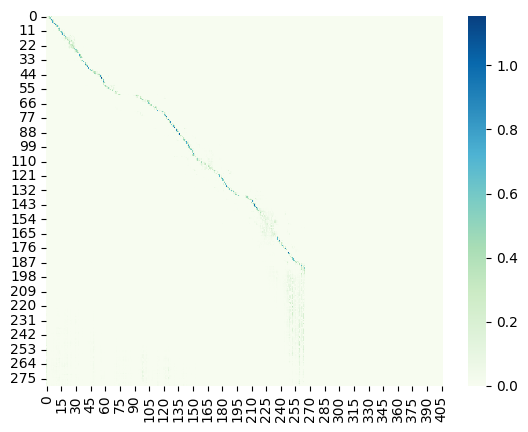

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfull.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfull-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    full_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    # if epoch == 3:
    #     break

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(full_model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
validate_full(full_model, val_loader)

In [ ]:
### TODO Unfreeze the weights of full transformer input embedding and decoder
# @NOTE: after unfreezing, continue training the P2 model for more epochs to achieve best results!

for param in full_model.encoder.embedding.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.encoder.projection.parameters():
    param.requires_grad = True # TODO make it trainable

for param in full_model.decoder.parameters():
    param.requires_grad = True # TODO make it trainable

## Testing

In [ ]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [33:52<00:00, 61.86s/it]

In [ ]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 532, in competition_submit
    url_result['createUrl'], quiet)
KeyError: 'createUrl'


# Part #3 (Improving your Model)
* Think of the input embedding, can you have something better than just an CNN-LSTM? Hint: HW3P2 might perform better.
* Think about the transformer encoder parameter, what about number of heads and number of layers, can this help?
* What about the decoder parameters what can  we improve there?
* We trained using an incremental training technique, can we use this technique to add more layers?

**Good Luck!!**

In [ ]:
full_model = FullTransformer(
input_dim                   = 27,
enc_num_layers              = config['enc_num_layers'],
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = config['enc_num_heads'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

full_model.load_state_dict(torch.load('/content/checkpointsfull/checkpoint-epochfull-0.pth')['model_state_dict'])

full_model_new = FullTransformer(
input_dim                   = 27,
enc_num_layers              = 3,
dec_num_layers              = config['dec_num_layers'],
enc_num_heads               = 2,
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = EOS_TOKEN,
sos_token                   = SOS_TOKEN,
pad_token                   = PAD_TOKEN,

dropout                     = config['enc_dropout'],

# decrease to a small number if you are just trying to implement the network
# we've computed the max length of the transcripts for you
trans_max_seq_length        = 550,
mfcc_max_seq_length         = dataset_max_len).to(device)

In [ ]:
def load_and_freeze_parameters(old_model, old_layers_number, new_model):
    #
    for old_layer, new_layer in zip(old_model.encoder.enc_layers, new_model.encoder.enc_layers):
        new_layer.load_state_dict(old_layer.state_dict())

    #
    for layer in new_model.encoder.enc_layers[0:old_layers_number]:
        for param in layer.parameters():
            param.requires_grad = False

    #
    for layer in new_model.encoder.enc_layers[old_layers_number:]:
        for param in layer.parameters():
            param.requires_grad = True



In [ ]:
load_and_freeze_parameters(full_model, 2, full_model_new)

In [ ]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False


# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}_Lr:{}".format(
    config["Name"],
    3,       # only used in Part II with the Transformer Encoder
    2,        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"],
    config['learning_rate'])

if USE_WANDB:

    wandb.login(key="b9fec08c02d03c41bdf5fe1f5268589277270fbe", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = "f0bqyz1j"
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24-2",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(full_model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


learning_rate,████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_perplexity,█▇▅▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_distance,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
train_loss,0.25548
train_perplexity,1.29121
val_distance,24.78438


## Loss, Optimizer, and Scheduler Definitions

In [ ]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [ ]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(full_model_new.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(full_model_new.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(full_model_new.parameters(), lr=float(config["learning_rate"]),
                                betas=(0.9, 0.999),
                                eps=1e-9,
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)


Epoch 1/50



Epoch 1/50: 
Train Loss 0.2852	 Train Perplexity 1.3302	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:54, 78.44s/it, running_distance=29.4062]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF IN NABLE SOLEN IN ATTRANCE TO HOME HIS BLODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:35<28:52, 42.27s/it, running_distance=20.2578]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:44<36:20, 54.51s/it, running_distance=20.0885]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPOSITED


Val:   9%|▉         | 4/43 [04:00<41:00, 63.10s/it, running_distance=23.2617]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SCHEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE ENTER INTO A STEWPAN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUE GENTLY TOOK QUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 23.4969


Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 0.2805	 Train Perplexity 1.3239	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 0.2747	 Train Perplexity 1.3163	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:33<23:45, 33.94s/it, running_distance=26.0625]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF IN NABLE SOLEN IN A TRANS TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [00:48<15:23, 22.52s/it, running_distance=18.2812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORN TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:57<29:15, 43.88s/it, running_distance=18.3438]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSSED HIM TO THE PALETIES OF THE JULIAN LAW BAST IN A FEEBLE GOVERNMENT AND A STIPER SITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:14<36:51, 56.70s/it, running_distance=21.9570]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WAITER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAND
Levenshtein Distance 23.2812


Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 0.2676	 Train Perplexity 1.3070	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 0.2611	 Train Perplexity 1.2985	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:53, 78.42s/it, running_distance=27.4531]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF A NABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:33<27:56, 40.89s/it, running_distance=19.3281]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:42<35:52, 53.80s/it, running_distance=19.1927]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITED


Val:   9%|▉         | 4/43 [03:14<29:23, 45.22s/it, running_distance=20.2539]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INCANCITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STUPIN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 20.2937


Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 0.2548	 Train Perplexity 1.2904	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 0.2474	 Train Perplexity 1.2808	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:54, 78.45s/it, running_distance=23.1406]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF INNABLE SOLEN IN ATTRANCE TO HOME HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:33<27:58, 40.93s/it, running_distance=16.4141]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:42<35:50, 53.75s/it, running_distance=15.9583]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSSED HIM TO THE PANELSIES OF THE JULIAN LAW BAST IN A FEEBLE GOVERNMENT AND A SIPPER SITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:58<40:45, 62.70s/it, running_distance=18.9531]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE ENDER INTO A STEWPAN WITH SUFFICIENT WANDER TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 19.7969


Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 0.2425	 Train Perplexity 1.2746	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 0.2368	 Train Perplexity 1.2674	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:55, 78.47s/it, running_distance=37.7656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF INNABLE SOLEN IN A TRANST TO HOLD HIS BODY STIFF AND UNDER SUPPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:33<28:00, 40.99s/it, running_distance=23.4531]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WERE AND YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:42<35:52, 53.82s/it, running_distance=21.5052]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITED


Val:   9%|▉         | 4/43 [03:58<40:46, 62.74s/it, running_distance=24.1328]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SCHEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPEN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 24.3875


Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.2317	 Train Perplexity 1.2608	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.2259	 Train Perplexity 1.2535	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:56, 78.49s/it, running_distance=30.8438]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF INABLE SOLEN IN A TRANST TO HOLD HIS BODY STIFF AND ON SOME PORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:34<28:24, 41.57s/it, running_distance=20.8828]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:00<22:55, 34.39s/it, running_distance=18.2448]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANEL HE'S OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SIPPER SITICIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:27<20:39, 31.79s/it, running_distance=20.1055]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SCHEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COO
Levenshtein Distance 20.5531


Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.2215	 Train Perplexity 1.2480	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.2161	 Train Perplexity 1.2413	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:52, 78.40s/it, running_distance=25.6719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SO UNING


Val:   5%|▍         | 2/43 [01:35<28:47, 42.14s/it, running_distance=17.5312]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE TO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:26, 35.17s/it, running_distance=15.4115]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SIPPER SITICES AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:31<21:19, 32.81s/it, running_distance=17.6602]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WAITER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.1969


Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.2112	 Train Perplexity 1.2353	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.2066	 Train Perplexity 1.2296	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<55:00, 78.59s/it, running_distance=26.5469]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNDER SUPPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:35<28:54, 42.31s/it, running_distance=17.7109]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:44<36:24, 54.61s/it, running_distance=16.4010]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALTIES OF THE JULIAN LAW BAST IN A FEEBLE GOVERNMENT AND A SUPER SITICIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:13<28:56, 44.53s/it, running_distance=17.6641]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.0594


Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.2024	 Train Perplexity 1.2244	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 0.1984	 Train Perplexity 1.2195	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:53, 78.42s/it, running_distance=33.1719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:35<28:44, 42.06s/it, running_distance=21.0938]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:44<36:18, 54.46s/it, running_distance=18.7135]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:14<29:11, 44.92s/it, running_distance=21.3906]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND A SCEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 21.7781


Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 0.1946	 Train Perplexity 1.2149	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 0.1908	 Train Perplexity 1.2102	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:53, 78.41s/it, running_distance=37.9219]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [01:35<28:44, 42.07s/it, running_distance=23.5625]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<23:23, 35.10s/it, running_distance=19.5885]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THIS DEAL OF CAROL EXPLOSED HIM TO THE PANELIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:29<20:55, 32.20s/it, running_distance=21.0039]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WAITER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 21.7844


Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 0.1869	 Train Perplexity 1.2056	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 0.1833	 Train Perplexity 1.2013	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [01:18<54:57, 78.52s/it, running_distance=36.6094]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:35<28:48, 42.15s/it, running_distance=21.9453]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:44<36:20, 54.52s/it, running_distance=19.8229]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [03:14<29:05, 44.77s/it, running_distance=21.8008]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SCEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPIN WITH SUFFICIENT WANDER TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 21.8094


Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 0.1795	 Train Perplexity 1.1967	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 0.1759	 Train Perplexity 1.1924	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:19<13:48, 19.72s/it, running_distance=24.1719]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [00:36<12:17, 17.98s/it, running_distance=16.7188]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:45<27:36, 41.42s/it, running_distance=15.6875]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:09<22:27, 34.56s/it, running_distance=18.4805]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDER TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 19.1062


Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 0.1728	 Train Perplexity 1.1887	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 0.1704	 Train Perplexity 1.1859	 Learning Rate 0.0001


Val:   2%|▏         | 1/43 [00:20<14:17, 20.41s/it, running_distance=22.7188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNCE SUPPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [00:36<12:24, 18.15s/it, running_distance=15.0156]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:04<14:51, 22.30s/it, running_distance=13.1562]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:32<16:01, 24.64s/it, running_distance=16.1328]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.4625


Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 0.1675	 Train Perplexity 1.1825	 Learning Rate 0.0001
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 0.1651	 Train Perplexity 1.1796	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:37<26:35, 38.00s/it, running_distance=23.3594]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNDERSON


Val:   5%|▍         | 2/43 [00:54<17:22, 25.44s/it, running_distance=15.4609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:21<17:21, 26.03s/it, running_distance=13.3490]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSITED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:45<16:24, 25.25s/it, running_distance=16.9805]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WAITER LAST LONGER AND THE SKEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDER TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.1094


Saved epoch model
Saved best training model

Epoch 28/50



Epoch 28/50: 
Train Loss 0.1621	 Train Perplexity 1.1761	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 29/50



Epoch 29/50: 
Train Loss 0.1594	 Train Perplexity 1.1729	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:46, 78.25s/it, running_distance=25.0312]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:34<28:41, 41.98s/it, running_distance=16.9688]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<23:23, 35.08s/it, running_distance=14.4792]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:25<20:00, 30.79s/it, running_distance=16.7734]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE FROM INCANSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.5312


Saved epoch model
Saved best training model

Epoch 30/50



Epoch 30/50: 
Train Loss 0.1579	 Train Perplexity 1.1711	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 31/50



Epoch 31/50: 
Train Loss 0.1551	 Train Perplexity 1.1678	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:53, 78.42s/it, running_distance=22.7188]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCED TO HOLD HIS BODY STIFF AND UNSUMPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:35<28:44, 42.06s/it, running_distance=15.2812]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:33, 35.34s/it, running_distance=13.0833]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<20:06, 30.93s/it, running_distance=15.8672]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.1094


Saved epoch model
Saved best training model

Epoch 32/50



Epoch 32/50: 
Train Loss 0.1529	 Train Perplexity 1.1653	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 33/50



Epoch 33/50: 
Train Loss 0.1514	 Train Perplexity 1.1635	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:55, 78.47s/it, running_distance=27.0938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [01:35<28:45, 42.07s/it, running_distance=17.8047]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:01<23:22, 35.06s/it, running_distance=15.4010]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<20:01, 30.81s/it, running_distance=17.9258]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.0500


Saved epoch model
Saved best training model

Epoch 34/50



Epoch 34/50: 
Train Loss 0.1498	 Train Perplexity 1.1617	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 35/50



Epoch 35/50: 
Train Loss 0.1477	 Train Perplexity 1.1593	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:54, 78.45s/it, running_distance=31.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND NOT SUPPORTED EXCEPTED TWO POINTS THE HEND AND HEELS


Val:   5%|▍         | 2/43 [01:35<28:43, 42.04s/it, running_distance=19.1719]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:33, 35.33s/it, running_distance=15.9635]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANELTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<20:05, 30.91s/it, running_distance=18.5469]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SCEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET ITS DUE GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.3781


Saved epoch model
Saved best training model

Epoch 36/50



Epoch 36/50: 
Train Loss 0.1462	 Train Perplexity 1.1575	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 37/50



Epoch 37/50: 
Train Loss 0.1455	 Train Perplexity 1.1567	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:55, 78.46s/it, running_distance=26.2656]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN A TRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [01:35<28:43, 42.04s/it, running_distance=16.8828]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:29, 35.23s/it, running_distance=14.4896]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:29<20:56, 32.21s/it, running_distance=17.2031]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SCEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 17.5188


Saved epoch model
Saved best training model

Epoch 38/50



Epoch 38/50: 
Train Loss 0.1434	 Train Perplexity 1.1542	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 39/50



Epoch 39/50: 
Train Loss 0.1423	 Train Perplexity 1.1529	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:59, 78.57s/it, running_distance=30.0938]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [01:35<28:48, 42.16s/it, running_distance=18.8906]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:33, 35.35s/it, running_distance=15.7604]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<20:08, 30.98s/it, running_distance=18.3125]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SCEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 18.3531


Saved epoch model
Saved best training model

Epoch 40/50



Epoch 40/50: 
Train Loss 0.1412	 Train Perplexity 1.1517	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 41/50



Epoch 41/50: 
Train Loss 0.1401	 Train Perplexity 1.1505	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<54:53, 78.42s/it, running_distance=24.2031]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [01:34<28:42, 42.02s/it, running_distance=15.5547]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:32, 35.32s/it, running_distance=13.4531]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<20:06, 30.93s/it, running_distance=15.7305]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND A SCEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.3906


Saved epoch model
Saved best training model

Epoch 42/50



Epoch 42/50: 
Train Loss 0.1398	 Train Perplexity 1.1501	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 43/50



Epoch 43/50: 
Train Loss 0.1397	 Train Perplexity 1.1500	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:23<16:36, 23.74s/it, running_distance=20.4375]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [00:40<13:26, 19.67s/it, running_distance=13.6953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:07<15:27, 23.18s/it, running_distance=12.0625]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:32<15:19, 23.59s/it, running_distance=14.4570]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.2562


Saved epoch model
Saved best training model

Epoch 44/50



Epoch 44/50: 
Train Loss 0.1377	 Train Perplexity 1.1477	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 45/50



Epoch 45/50: 
Train Loss 0.1377	 Train Perplexity 1.1476	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:20<14:00, 20.01s/it, running_distance=22.1250]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [00:36<12:20, 18.06s/it, running_distance=14.5469]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:04<14:52, 22.31s/it, running_distance=12.6094]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:34<16:32, 25.46s/it, running_distance=15.1875]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 15.6062


Saved epoch model
Saved best training model

Epoch 46/50



Epoch 46/50: 
Train Loss 0.1372	 Train Perplexity 1.1472	 Learning Rate 0.0000
Saved epoch model
Saved best training model

Epoch 47/50



Epoch 47/50: 
Train Loss 0.1370	 Train Perplexity 1.1469	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [00:23<16:35, 23.70s/it, running_distance=24.2500]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [00:40<13:21, 19.55s/it, running_distance=15.6562]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [01:07<15:24, 23.10s/it, running_distance=13.3594]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [01:35<16:07, 24.81s/it, running_distance=15.7539]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.4156


Saved epoch model
Saved best training model

Epoch 48/50



Epoch 48/50: 
Train Loss 0.1371	 Train Perplexity 1.1469	 Learning Rate 0.0000
Saved epoch model

Epoch 49/50



Epoch 49/50: 
Train Loss 0.1368	 Train Perplexity 1.1466	 Learning Rate 0.0000


Val:   2%|▏         | 1/43 [01:18<55:02, 78.64s/it, running_distance=25.4844]


Ground Truth :  THE STRENGTH THAT ENABLES SOMEONE IN A TRANCE TO HOLD HIS BODY STIFF AND UNSUPPORTED EXCEPT AT TWO POINTS THE HEAD AND HEELS
Prediction   :  THE STRENGTH OF ENABLE SOLEN IN ATTRANCE TO HOLD HIS BODY STIFF AND UNDERSOME


Val:   5%|▍         | 2/43 [01:35<28:45, 42.09s/it, running_distance=16.2734]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HEAD GENTLY IN GRATITUDE WERE INTO YOU HAPPY THEN AT ALL


Val:   7%|▋         | 3/43 [02:02<23:32, 35.31s/it, running_distance=13.6823]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  THE ZEAL OF CAROL EXPOSED HIM TO THE PANALITIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSITIOUS AGE HE WAS THE CURE OF IMPUNITY AND EVEN OF PRAISE


Val:   9%|▉         | 4/43 [02:26<20:06, 30.92s/it, running_distance=15.8555]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND THE SKEEP MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING



Ground Truth :  PUT THE UDDER INTO A STEWPAN WITH SUFFICIENT WATER TO COVER IT LET IT STEW GENTLY TILL QUITE DONE WHEN TAKE IT OUT TO COOL
Prediction   :  BUT THE UTTER INTO A STEWPAN WITH SUFFICIENT WANDERED TO COVER IT LET IT STOOD GENTLY TO ACQUITE DONE WHEN TAKE IT OUT TO COOL
Levenshtein Distance 16.5750


Saved epoch model
Saved best training model

Epoch 50/50



Epoch 50/50: 
Train Loss 0.1365	 Train Perplexity 1.1464	 Learning Rate 0.0000
Saved epoch model
Saved best training model


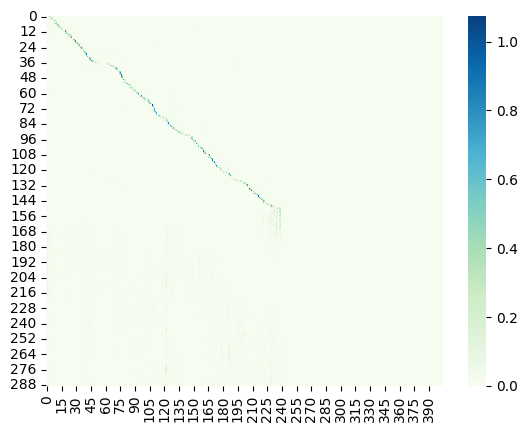

In [ ]:
###  Now let's train the encoder to master the encoder input ranges
e                   = 0
best_loss           = 10.0

checkpoint_root = os.path.join(os.getcwd(), 'checkpointsfull_new')
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(full_model_new, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-modelfullnew.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epochfullnew-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    full_model_new.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(full_model_new, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(full_model_new, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))

        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})

    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    attention_weights_decoder_self       = attention_weights[attention_keys[0]][0].cpu().detach().numpy()
    attention_weights_decoder_cross      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()
    save_attention_plot(attention_weights_decoder_cross, epoch)

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(full_model_new, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    # the first time we add the transformer encoder block, we freeze all other weights
    #   except the transformer encoder weights and train this partially-frozen model
    #   for about 3 epochs to weight initialize the transformer encoder weights.
    #   This speeds up convergence of the entire network.
    # if epoch == 3:
    #     break

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(full_model_new, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

In [ ]:
def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True


In [ ]:
unfreeze_model(full_model_new)

## Testing

In [46]:
checkpoint = torch.load('/content/checkpointsfull/checkpoint-best-loss-modelfull.pth')


incompatible_keys = full_model.load_state_dict(checkpoint['model_state_dict'], strict=False)

print("Missing keys:", incompatible_keys.missing_keys)
print("Unexpected keys:", incompatible_keys.unexpected_keys)

Missing keys: []
Unexpected keys: []


In [47]:
full_model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = full_model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 41/41 [33:58<00:00, 65.41s/it]

In [49]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("improved.csv", index=False)

/content


In [ ]:
!kaggle competitions submit -c hw4p2-sp24 -f improved.csv -m "It's been a ride :)"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 561, in competition_submit_cli
    submit_result = self.competition_submit(file_name, message,
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 532, in competition_submit
    url_result['createUrl'], quiet)
KeyError: 'createUrl'


# HW3P2 model


### Pyramid Bi-LSTM (pBLSTM)

In [ ]:
# Utils for network
torch.cuda.empty_cache()
# from torch.autograd import Variable

class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

class LockedDropout(nn.Module):
    """ LockedDropout applies the same dropout mask to every time step.

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.25):
        self.p = p
        super().__init__()

    def forward(self, x):
        """
        Args:
            x (:class:`torch.FloatTensor` [sequence length, batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not self.training or not self.p:
            return x
        x = x.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        return x * mask


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'


In [ ]:
class pBLSTM(torch.nn.Module):

    '''
    Pyramidal BiLSTM
    Read the write up/paper and understand the concepts and then write your implementation here.

    At each step,
    1. Pad your input if it is packed (Unpack it)
    2. Reduce the input length dimension by concatenating feature dimension
        (Tip: Write down the shapes and understand)
        (i) How should  you deal with odd/even length input?
        (ii) How should you deal with input length array (x_lens) after truncating the input?
    3. Pack your input
    4. Pass it into LSTM layer

    To make our implementation modular, we pass 1 layer at a time.
    '''

    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, num_layers=3, bidirectional=True, dropout = 0.3)  # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        #could drop out
    def forward(self, x_packed): # x_packed is a PackedSequence

        # TODO: Pad Packed Sequence
        seq_unpacked, lens_unpacked = pad_packed_sequence(x_packed, batch_first=True)
        # print(f'in the plstm section after pad {seq_unpacked.shape},{lens_unpacked.shape}')
        # Call self.trunc_reshape() which downsamples the time steps of x and increases the feature dimensions as mentioned above
        x, x_lens = self.trunc_reshape(x=seq_unpacked, x_lens=lens_unpacked)
        # print(f'in the plstm section after truncate {x.shape},{x_lens.shape}')
        # self.trunc_reshape will return 2 outputs. What are they? Think about what quantites are changing.
        # TODO: Pack Padded Sequence. What output(s) would you get?
        PackedSequence = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # TODO: Pass the sequence through bLSTM
        packed_output, (_, _) = self.blstm(PackedSequence)
        # What do you return?

        return packed_output

    def trunc_reshape(self, x, x_lens):
        # TODO: If you have odd number of timesteps, how can you handle it? (Hint: You can exclude them)
        # TODO: Reshape x. When reshaping x, you have to reduce number of timesteps by a downsampling factor while increasing number of features by the same factor
        # TODO: Reduce lengths by the same downsampling factor
        # The shape of x is [batch_size, frames, features]
        batch_size = x.shape[0]
        frames = x.shape[1]
        features = x.shape[2]
        if frames % 2 != 0:
            x = x[:, :-1, :]
        x = x.reshape((batch_size, x.shape[1]//2, features*2))
        x_lens = x_lens/2
        return x, x_lens

### Encoder

In [ ]:
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()

        self.PermuteBlock = PermuteBlock()
        self.embedding = torch.nn.Sequential(torch.nn.Conv1d(in_channels=input_size,out_channels=64,kernel_size=3,padding=1,stride=1),
                                             torch.nn.BatchNorm1d(64),
                                             torch.nn.GELU(),
                                             torch.nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
                                             torch.nn.BatchNorm1d(128),
                                             torch.nn.GELU(),
                                             torch.nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
                                             torch.nn.BatchNorm1d(256),
                                             torch.nn.GELU()
                                             )
        self.lstm_layers = torch.nn.ModuleList()
        for i in range(2):
            input_size_pblstm = 256 if i == 0 else encoder_hidden_size * 2
            self.lstm_layers.append(pBLSTM(input_size=input_size_pblstm, hidden_size=encoder_hidden_size))
            self.lstm_layers.append(LockedDropout())

    def forward(self, x, x_lens):
        # Where are x and x_lens coming from? The dataloader
        #TODO: Call the permute layer and embedding layer
        x = self.PermuteBlock(x)
        x = self.embedding(x)
        x = self.PermuteBlock(x)
        # # TODO: Pack Padded Sequence
        # packed = pack_padded_sequence(input=x,lengths=x_lens,batch_first=True,enforce_sorted=False)
        # # TODO: Pass Sequence through the pyramidal Bi-LSTM layer
        # x = self.pBLSTM1(packed)
        # # TODO: Pad Packed Sequence
        # encoder_outputs, encoder_lens= pad_packed_sequence(sequence=x,batch_first=True)
        # print(f'The output from plstm, {encoder_outputs.shape},{encoder_lens.shape}')
        for layer in self.lstm_layers:
            if isinstance(layer, pBLSTM):
                x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
                x_packed = layer(x_packed)
                x, x_lens = pad_packed_sequence(x_packed, batch_first=True)
            else:
                x = torch.permute(x, (1, 0, 2))
                x = layer(x)
                x = torch.permute(x,(1,0,2))
        # Remember the number of output(s) each function returns

        return x, x_lens


### Decoder

In [ ]:
class HW3P2_encoder(torch.nn.Module):

    def __init__(self, input_size, embed_size= 192):
        super().__init__()

        self.encoder        = Encoder(input_size=input_size, encoder_hidden_size=embed_size*2)

    def forward(self, x, lengths_x):

        encoder_out, encoder_lens   = self.encoder(x, lengths_x)
        return encoder_out, encoder_lens

## Initialize ASR Network

In [ ]:
HW3P2_encoder = HW3P2_encoder(
    input_size  = 27,
    embed_size  = 192,
).to(device)
print(HW3P2_encoder)

ASRModel(
  (augmentations): Sequential()
  (encoder): Encoder(
    (PermuteBlock): PermuteBlock()
    (embedding): Sequential(
      (0): Conv1d(27, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): GELU(approximate='none')
      (6): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): GELU(approximate='none')
    )
    (lstm_layers): ModuleList(
      (0): pBLSTM(
        (blstm): LSTM(512, 384, num_layers=3, dropout=0.3, bidirectional=True)
      )
      (1): LockedDropout(p=0.25)
      (2): pBLSTM(
        (blstm): LSTM(1536, 384, num_layers=3, dropout=0.3, bidirectional=True

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_augmentations,-,"[64, 2936, 27]",NaN,NaN
1_encoder.PermuteBlock_PermuteBlock,-,"[64, 27, 2936]",NaN,NaN
2_encoder.embedding.Conv1d_0,"[27, 64, 3]","[64, 64, 2936]",5248.0,15220224.0
3_encoder.embedding.BatchNorm1d_1,[64],"[64, 64, 2936]",128.0,64.0
4_encoder.embedding.GELU_2,-,"[64, 64, 2936]",NaN,NaN
5_encoder.embedding.Conv1d_3,"[64, 128, 3]","[64, 128, 2936]",24704.0,72155136.0
6_encoder.embedding.BatchNorm1d_4,[128],"[64, 128, 2936]",256.0,128.0
7_encoder.embedding.GELU_5,-,"[64, 128, 2936]",NaN,NaN
8_encoder.embedding.Conv1d_6,"[128, 256, 3]","[64, 256, 2936]",98560.0,288620544.0
